## Prediction of the device health based on the hardware and software performance

**Problem**: Companies are losing a significant amount of employee’s time due to unexpected hardware crashes and the necessity to reimage or replace a device. A solution that would predict a coming hardware crash and allow time to address the issue beforehand and without any disruption to work could significantly increase the workforce productivity and save millions of dollars.

**Client**: Companies of any size and individual users.

**Data**: The PC test performance data that includes information on the physical/virtual memory, RAM, and software errors. The data set has 5,609,148 rows and 12 features (input variables) stored in a .csv file.

Description of the variables:

* `pcid`: Device ID

* `date`: The day the measurement was taken. The missing values are imputed using the forward-fill and back-fill propagation, as well as taking an average approaches.

* `free_physical_memory`: How much free physical memory was available on a device on a given date (in Mb)

* `free_virtual_memory`: How much free virtual memory was available on a device on a given date (in Mb)

* `daily_average_ram`: Percentage of RAM in use per day (sampled each minute and averaged)

* `daily_std_dev_ram`: The standard deviation from `daily_average_ram` (sampled each minute and averaged)

* `windows_events_count`: Whether an Error or Critical Windows event occured on a given day 

* `has_bios_error`: Whether a device reported an error on a given day

* `driver_crash_count`: How many driver crashes occured on a device on a given day

* `average_time_since_last_boot`: Time since the last Windows start (in ms)

* `next_reimage`: The date and time when a device is expected to have the next OS reimage. This date is defined retrospectively by capturing the actual reimage date later on.
    
* `zone`: The risk zone of the device, indicating when a device will require a reimage. This variable is the label we'll be trying to predict. This variable is defined by the `next_reimage` variable as per below:
    
    - Zone 0: Device is healthy (the date of next reimage is NaN)
    - Zone 1: Device will have a reimage in the next 0-10 days
    - Zone 2: Device will have a reimage in the next 11-20 days
    - Zone 3: Device will have a reimage in the next 21-30 days
    - Zone 4: Device will have a reimage in the next 31-40 days
    - Zone 5: Device will have a reimage in the next 41-50 days
    - Zone 6: Device will have a reimage in the next 51-60 days

**Method**: The expected result of the project is to predict the timeline of the expected necessary re-image of a PC. A number of classification methods will be used to choose the best method for predicting the `zone` variable.

**Deliverables**: The outcome of the project will be presented in a form of Jupyter notebook, as well as the blog post on Medium.


### Exploratory Data Analysis

Loading required libraries and the dataset:

In [1]:
#Pandas for dataframes
import pandas as pd
#Changing default display option to display all columns
pd.set_option('display.max_columns', 21)

#Numpy for numerical computing
import numpy as np

#Matplotlib for visualization
import matplotlib.pyplot as plt

#Display plots in the notebook
%matplotlib inline 

#Seaborn for easier visualization
import seaborn as sns

#Stats package for statistical analysis
from scipy import stats

#Machine learning packages
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, confusion_matrix, classification_report

In [2]:
#Loading the data set
df = pd.read_csv('/Users/abdarabdar/Documents/sw_health_raw_data.csv', parse_dates=True)

**Parameters of the dataset**

Let's look at the overall characteristics of the dataset, starting with the dataset shape, number and types of variables. 

In [3]:
#Dataframe dimensions
df.shape

(5609148, 12)

In [4]:
#Types of variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5609148 entries, 0 to 5609147
Data columns (total 12 columns):
zone                            int64
next_reimage                    object
date                            object
free_physical_memory            float64
free_virtual_memory             float64
daily_average_ram               float64
daily_std_dev_ram               float64
windows_events_count            float64
has_bios_error                  int64
driver_crash_count              float64
average_time_since_last_boot    float64
pcid                            object
dtypes: float64(7), int64(2), object(3)
memory usage: 513.5+ MB


Most of the variables are numeric. Let's look at the first and last 5 rows of the data:

In [5]:
df.head()

,zone,next_reimage,date,free_physical_memory,free_virtual_memory,daily_average_ram,daily_std_dev_ram,windows_events_count,has_bios_error,driver_crash_count,average_time_since_last_boot,pcid
0,0,NaN,2017-12-22,3312.5,3693.0,56.735933,1.851660,1.0,0,0.0,1.519691e+06,61d1ce206fb0d40117ad5a762b86972f51c75de8ebd6e1...
1,0,NaN,2017-12-22,3699.0,8911.0,49.706861,2.353272,1.0,1,0.0,1.833904e+04,7b5a90c8c7f13a7f1aa96e0b65e013e75e191e34b3296d...
2,0,NaN,2017-12-22,1787.0,2423.0,77.401547,1.498973,1.0,0,0.0,2.935453e+06,2b1b3b12fb5f7b300d1ab3de6cb209cf279795ffe9b5e3...
3,0,NaN,2017-12-22,10598.0,13119.0,35.569576,1.609778,1.0,0,0.0,7.041347e+03,9d497b6b17459fccedfd37aeb2fd1789e01ec6214a748a...
4,0,NaN,2017-12-22,5060.0,5968.0,34.740309,1.634479,1.0,0,0.0,5.214318e+05,453035355e9e7930610f6866c5e63e225fb7e61c1ecfea...


In [6]:
df.tail()

,zone,next_reimage,date,free_physical_memory,free_virtual_memory,daily_average_ram,daily_std_dev_ram,windows_events_count,has_bios_error,driver_crash_count,average_time_since_last_boot,pcid
5609143,0,NaN,2017-11-27,3736.0,11865.0,75.923269,7.046765,1.0,0,0.0,2.234844e+06,00368a64efce538e7a43fabcfbe6bdfac2a316dc7074a3...
5609144,0,NaN,2017-11-27,8602.0,10341.0,45.273042,2.765385,1.0,0,0.0,6.082382e+05,479b80338e81b700b0210ec67d5f0bde9a80f53e5dc493...
5609145,0,NaN,2017-11-27,4752.0,6172.0,43.395437,2.335085,0.0,0,19.0,6.465962e+05,cc9603c452df57f54db0e3987a5ec88e275596e98cdcf1...
5609146,0,NaN,2017-11-27,5085.0,6518.0,57.548151,3.355863,1.0,0,20.0,1.470173e+06,6da29dfe3ddb6af696ec5321a129338c9d2547ca95374e...
5609147,0,NaN,2017-11-27,4563.0,5660.0,43.239631,3.294113,1.0,1,5.0,3.497002e+02,e54c81817301edde8669a8eba2bd9a72dbcf6b0d5a2c32...


The data on both ends look consistent, and there are no obvious errors. There are NaNs in the 'next_reimage' column, which correspond to zone = 0. Since the 'next_reimage' defines the 'zone' variable, we don't need to keep both in the data set and can keep the 'zone' variable only for the purposes of predictive model building.

Let's now check if the variables have any missing values:

In [7]:
#Checking for NaNs
for i in df.columns:
    print(i, ": ", df.loc[:,i].isnull().values.any())

zone :  False
next_reimage :  True
date :  False
free_physical_memory :  False
free_virtual_memory :  False
daily_average_ram :  False
daily_std_dev_ram :  False
windows_events_count :  False
has_bios_error :  False
driver_crash_count :  False
average_time_since_last_boot :  False
pcid :  False


There are no missing values in the data except the 'next_reimage' column, which is expected. The `date` variable was imputed beforehand, as mentioned before, so there are no missing values as well.

Before exploring the distributions of the variables, let's do some cleaning. We'll convert the 'date' into datetime object and drop the 'next_reimage' variable. Additionally, let's rename the 0 level of the 'zone' variable as '7', so that the health grade progression looks more logical.

In [8]:
#Cleaning the data set
df_cleaned = df.copy()
df_cleaned['date'] = pd.to_datetime(df_cleaned.date)
df_cleaned = df_cleaned.drop('next_reimage', axis=1)
df_cleaned.zone.replace(0, 7, inplace=True)

Next, let's look at the distributions of the numerical variables in the data set:

In [9]:
#Obtaining the distributions of the numerical variables
df_cleaned.describe()

,zone,free_physical_memory,free_virtual_memory,daily_average_ram,daily_std_dev_ram,windows_events_count,has_bios_error,driver_crash_count,average_time_since_last_boot
count,5.609148e+06,5.609148e+06,5.609148e+06,5.609148e+06,5.609148e+06,5.609148e+06,5.609148e+06,5.609148e+06,5.609148e+06
mean,6.944877e+00,5.301039e+03,9.390899e+03,5.084281e+01,2.291617e+00,9.485640e-01,2.220950e-01,3.561113e+00,-1.684183e+06
std,3.258081e-01,5.685789e+03,9.375644e+03,1.407656e+01,4.891270e+00,2.208853e-01,4.156547e-01,6.910196e+00,7.444881e+08
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.518875e+11
25%,7.000000e+00,3.112000e+03,4.594000e+03,4.280038e+01,1.387752e+00,1.000000e+00,0.000000e+00,0.000000e+00,3.691686e+04
50%,7.000000e+00,3.969000e+03,6.805500e+03,5.034052e+01,2.110890e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.241845e+05
75%,7.000000e+00,4.906000e+03,1.159400e+04,5.955315e+01,2.931696e+00,1.000000e+00,0.000000e+00,5.000000e+00,6.537925e+05
max,7.000000e+00,2.561550e+05,3.819300e+05,1.418681e+03,7.412071e+03,1.000000e+00,1.000000e+00,6.080000e+02,1.199125e+09


The summary highlights several interesting moments. First of all, variables 'free_physical_memory', 'free_virtual_memory' and 'daily_average_ram' all have minimum values of zero, which doesn't make sense. Whatever the system's performance may be, the minimum for those values can't be zero in real life. Next, 'average_time_since_last_boot' has negative values, which also doesn't make sense. The maximum value for 'daily_average_ram' is 1418.6%, which can't be true. 

Let's look at the number of instances where such cases take place:

In [10]:
#Number of instances for 'free_physical_memory'
df_cleaned[df_cleaned['free_physical_memory'] == 0].count()

zone                            78
date                            78
free_physical_memory            78
free_virtual_memory             78
daily_average_ram               78
daily_std_dev_ram               78
windows_events_count            78
has_bios_error                  78
driver_crash_count              78
average_time_since_last_boot    78
pcid                            78
dtype: int64

In [11]:
#Number of instances for 'free_virtual_memory'
df_cleaned[df_cleaned['free_virtual_memory'] == 0].count()

zone                            78
date                            78
free_physical_memory            78
free_virtual_memory             78
daily_average_ram               78
daily_std_dev_ram               78
windows_events_count            78
has_bios_error                  78
driver_crash_count              78
average_time_since_last_boot    78
pcid                            78
dtype: int64

In [12]:
#Number of instances for 'daily_average_ram'
df_cleaned[df_cleaned['daily_average_ram'] > 100].count()

zone                            20
date                            20
free_physical_memory            20
free_virtual_memory             20
daily_average_ram               20
daily_std_dev_ram               20
windows_events_count            20
has_bios_error                  20
driver_crash_count              20
average_time_since_last_boot    20
pcid                            20
dtype: int64

In [13]:
#Number of instances for 'average_time_since_last_boot'
df_cleaned[df_cleaned['average_time_since_last_boot'] <= 0].count()

zone                            329
date                            329
free_physical_memory            329
free_virtual_memory             329
daily_average_ram               329
daily_std_dev_ram               329
windows_events_count            329
has_bios_error                  329
driver_crash_count              329
average_time_since_last_boot    329
pcid                            329
dtype: int64

All the above cases represent a tiny fraction of the data set and can be dropped. Let's drop those instances:

In [14]:
#Dropping the erroneous instances
df_cleaned = df_cleaned.loc[(df_cleaned['free_physical_memory'] > 0)]
df_cleaned = df_cleaned.loc[(df_cleaned['free_virtual_memory'] > 0)]
df_cleaned = df_cleaned.loc[(df_cleaned['daily_average_ram'] <= 100)]
df_cleaned = df_cleaned.loc[(df_cleaned['average_time_since_last_boot'] > 0)]

The time period represented in the data set:

In [15]:
print('Earliest date:', min(df_cleaned['date']))
print('Latest date:', max(df_cleaned['date']))

Earliest date: 2017-10-01 00:00:00
Latest date: 2017-12-31 00:00:00


Next, let's look at how the variables are distributed per levels of our response variable ('zone). Plotting even a single barplot for this amount of data takes a lot of computation time, so we'll evaluate the distribution properties of the variables, using the summary tables, and plot graphs for those distributions. First, let's look at the number of responses by zone:

In [16]:
df_cleaned.groupby('zone').count()

,date,free_physical_memory,free_virtual_memory,daily_average_ram,daily_std_dev_ram,windows_events_count,has_bios_error,driver_crash_count,average_time_since_last_boot,pcid
zone,,,,,,,,,,
1,4744,4744,4744,4744,4744,4744,4744,4744,4744,4744
2,4392,4392,4392,4392,4392,4392,4392,4392,4392,4392
3,3904,3904,3904,3904,3904,3904,3904,3904,3904,3904
4,3424,3424,3424,3424,3424,3424,3424,3424,3424,3424
5,2857,2857,2857,2857,2857,2857,2857,2857,2857,2857
6,227168,227168,227168,227168,227168,227168,227168,227168,227168,227168
7,5362232,5362232,5362232,5362232,5362232,5362232,5362232,5362232,5362232,5362232


Almost 96% of the entries of data set belongs to zone 7 (no issues with a PC), which is logical--modern PCs rarely require reimaging due to software mailfunction. In fact, zones 1 to 5 represent only 0.3% of all data. This makes the data set very imbalanced, which makes the standard model evaluation metrics like accuracy score not applicable for this case. Between the zones 1-5, the number of rows is approximately same per each zone, and zone 6 has about 10 times more observations than the previous 5 zones.

Let's now look if the mean values of the variables differ substantially per each zone:

In [17]:
#Summary of the variables' means by zone
df_cleaned.groupby('zone').mean()

,free_physical_memory,free_virtual_memory,daily_average_ram,daily_std_dev_ram,windows_events_count,has_bios_error,driver_crash_count,average_time_since_last_boot
zone,,,,,,,,
1,5689.961847,7141.894920,43.450031,2.433392,0.991568,0.635540,1.293845,161911.383390
2,5607.262295,7085.832878,43.530662,2.428357,0.990893,0.631603,1.307491,166597.664664
3,5543.077357,7062.772733,43.592996,2.450788,0.988986,0.625000,1.294057,152235.689295
4,5430.115362,7075.584112,43.858824,2.439284,0.985397,0.610981,1.289282,162652.625492
5,5334.342623,7007.746038,44.457813,2.413281,0.982499,0.584179,1.465698,183635.428949
6,5389.859053,8765.700443,50.433930,2.375686,0.991328,0.206759,3.210078,414616.464337
7,5296.443470,9425.817533,50.885559,2.281541,0.946609,0.221282,3.584175,521823.738724


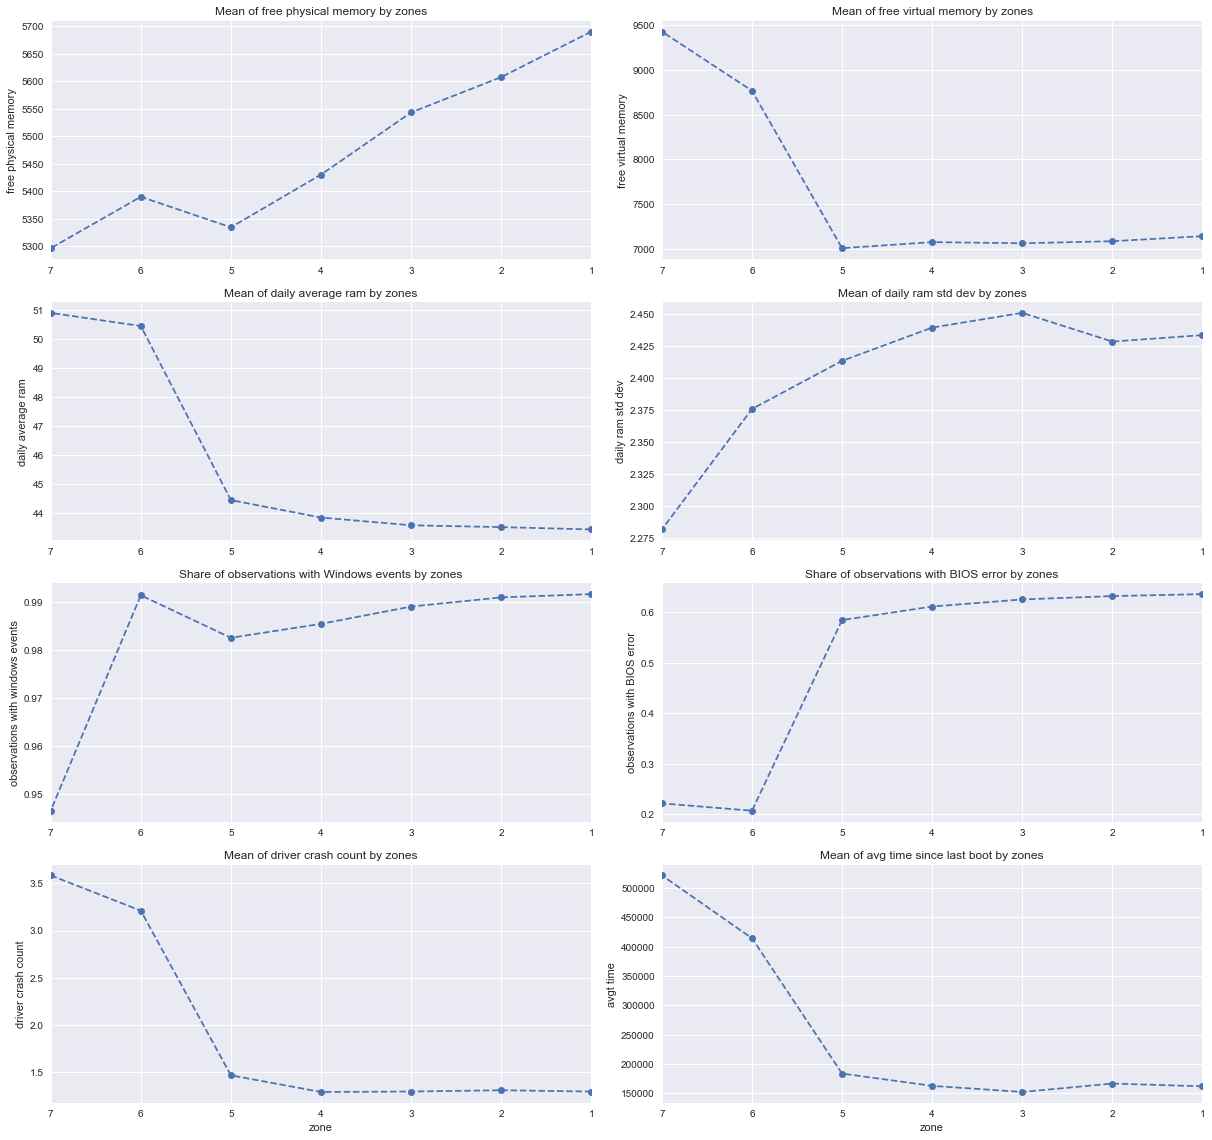

In [18]:
#Converting a 'groupby' object to a DataFrame
means = df_cleaned.groupby('zone').mean().reset_index()

#Plotting the charts
plt.figure(figsize=(17,16))
plt.subplot(4,2,1)
plt.title('Mean of free physical memory by zones')
plt.plot('zone', 'free_physical_memory', data= means, marker='o', linestyle='dashed')
plt.ylabel('free physical memory')
plt.xlim(7,1)

plt.subplot(4,2,2)
plt.title('Mean of free virtual memory by zones')
plt.plot('zone', 'free_virtual_memory', data= means, marker='o', linestyle='dashed')
plt.ylabel('free virtual memory')
plt.xlim(7,1)

plt.subplot(4,2,3)
plt.title('Mean of daily average ram by zones')
plt.plot('zone', 'daily_average_ram', data= means, marker='o', linestyle='dashed')
plt.ylabel('daily average ram')
plt.xlim(7,1)

plt.subplot(4,2,4)
plt.title('Mean of daily ram std dev by zones')
plt.plot('zone', 'daily_std_dev_ram', data= means, marker='o', linestyle='dashed')
plt.ylabel('daily ram std dev')
plt.xlim(7,1)

plt.subplot(4,2,5)
plt.title('Share of observations with Windows events by zones')
plt.plot('zone', 'windows_events_count', data= means, marker='o', linestyle='dashed')
plt.ylabel('observations with windows events')
plt.xlim(7,1)

plt.subplot(4,2,6)
plt.title('Share of observations with BIOS error by zones')
plt.plot('zone', 'has_bios_error', data= means, marker='o', linestyle='dashed')
plt.ylabel('observations with BIOS error')
plt.xlim(7,1)

plt.subplot(4,2,7)
plt.title('Mean of driver crash count by zones')
plt.plot('zone', 'driver_crash_count', data= means, marker='o', linestyle='dashed')
plt.xlabel('zone')
plt.ylabel('driver crash count')
plt.xlim(7,1)

plt.subplot(4,2,8)
plt.title('Mean of avg time since last boot by zones')
plt.plot('zone', 'average_time_since_last_boot', data= means, marker='o', linestyle='dashed')
plt.xlabel('zone')
plt.ylabel('avgt time')
plt.xlim(7,1)

plt.tight_layout() 
plt.show()

Based on the above, we can make several observations. First, the mean amount of free physical memory tends to increase slightly as a device approaches the critical state (zone 1), and the amount of free virtual memory drops significantly as a device goes out of zones 7-6 into zone 5. The mean of the daily average RAM drops by about 6 p.p. as the device approaches critical state, while the standard deviation of that mean increases. 

About 95% of observations in zone 7 had Windows events, while for other zones this variable approaches 99%. The share of the observations with BIOS errors increases dramatically as the devices enter zones 5-1, so this variable can potentially be a strong predictor of the upcoming device reimage.

Lastly, the mean count of driver crashes actually decreases as the devices approach critical state. The mean of the average time since last boot decreases substantially as well, which means that the devices approaching critical state tend to be rebooted more often.

In general, all predictors demonstrate visible differences between the zones, though the absolute values of differences aren't large. We will need to test if those differences are statistically significant.

Now, let's look at the skewness of the variables' distribution by zone, using the Pearson's coefficient of skewness:

In [259]:
#Calculating Pearson's coefficient of skewness for the predictors vs. the levels of the 'zone' variable
3*(df_cleaned.groupby('zone').mean() - df_cleaned.groupby('zone').median())/df_cleaned.groupby('zone').std()

,free_physical_memory,free_virtual_memory,daily_average_ram,daily_std_dev_ram,windows_events_count,has_bios_error,driver_crash_count,average_time_since_last_boot
zone,,,,,,,,
1,0.787736,0.846099,0.063078,0.331193,-0.276613,-2.271587,1.104442,0.931668
2,0.746553,0.777091,0.079758,0.321594,-0.287579,-2.290909,1.084470,0.992702
3,0.701172,0.716117,0.138551,0.300646,-0.316556,-2.323492,1.049556,1.102572
4,0.653166,0.722218,0.190760,0.333714,-0.365149,-2.393476,1.045438,1.047326
5,0.568807,0.643652,0.310810,0.268911,-0.400322,-2.530610,1.052369,1.159731
6,0.817862,1.008737,0.085554,0.395095,-0.280589,1.531616,1.530614,0.979725
7,0.698515,0.808508,0.108010,0.387619,-0.712476,1.599207,1.548822,0.341087


The distributions of the predictors are substantially skewed for all zones, which means that there is a substantial number of outliers, and most variables have a positive skew. Let's look at the boxplot for these variables by zone. For computational efficiency, I will have to drop tha values for zone 7. Also, since the standard boxplot() function for Pandas doesn't produce an agreeable result, I will have to create a manual grid for 48 charts overall.

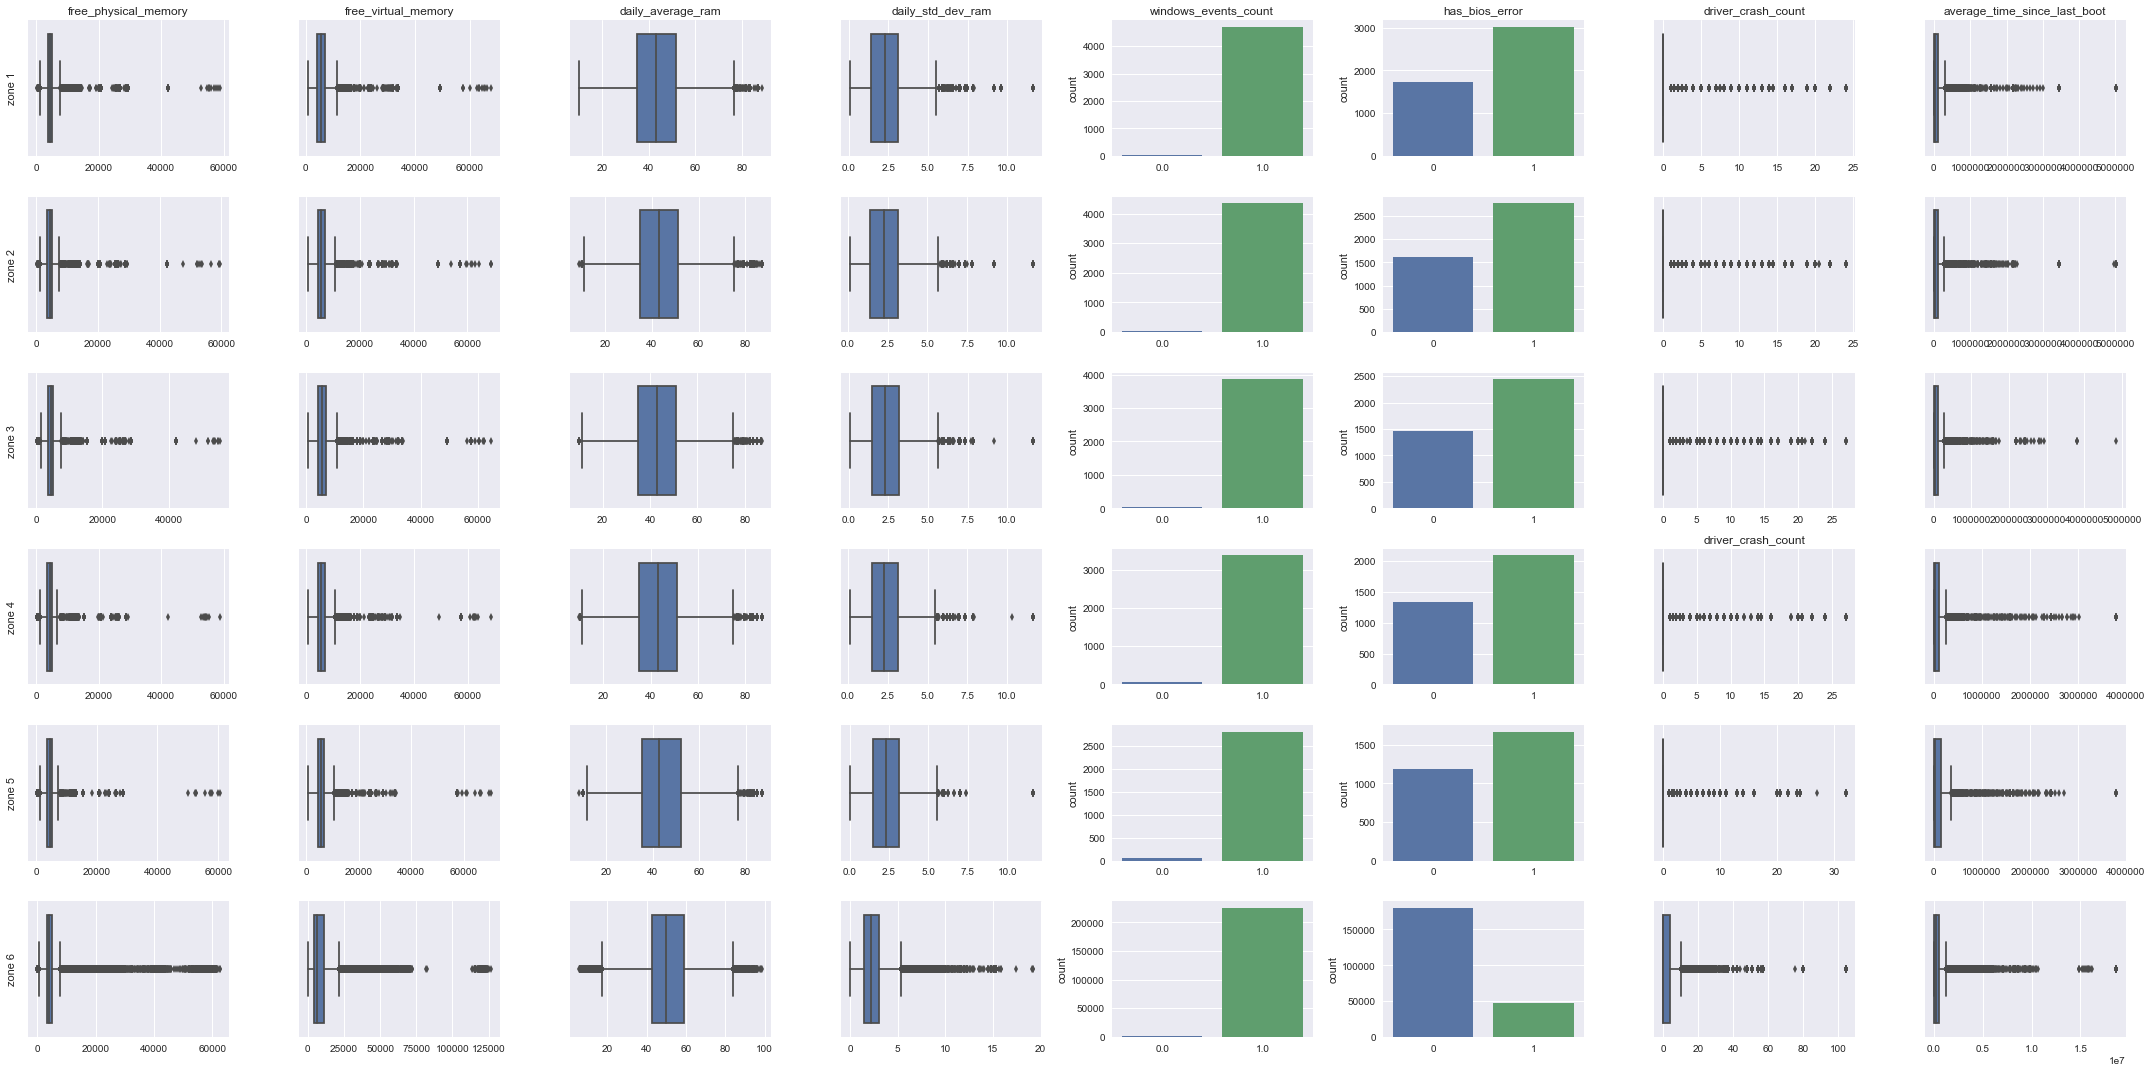

In [260]:
df_2 = df_cleaned.loc[df_cleaned['zone'] != 7]

plt.figure(figsize=(30,15))

#First row
plt.subplot(6,8,1)
plt.title('free_physical_memory')
sns.boxplot(x='free_physical_memory', data=df_2.loc[df_cleaned['zone'] == 1])
plt.ylabel('zone 1')
plt.xlabel(' ')

plt.subplot(6,8,2)
plt.title('free_virtual_memory')
sns.boxplot(x='free_virtual_memory', data=df_2.loc[df_cleaned['zone'] == 1])
plt.xlabel(' ')

plt.subplot(6,8,3)
plt.title('daily_average_ram')
sns.boxplot(x='daily_average_ram', data=df_2.loc[df_cleaned['zone'] == 1])
plt.xlabel(' ')

plt.subplot(6,8,4)
plt.title('daily_std_dev_ram')
sns.boxplot(x='daily_std_dev_ram', data=df_2.loc[df_cleaned['zone'] == 1])
plt.xlabel(' ')

plt.subplot(6,8,5)
plt.title('windows_events_count')
sns.countplot(x='windows_events_count', data=df_2.loc[df_cleaned['zone'] == 1])
plt.xlabel(' ')

plt.subplot(6,8,6)
plt.title('has_bios_error')
sns.countplot(x='has_bios_error', data=df_2.loc[df_cleaned['zone'] == 1])
plt.xlabel(' ')

plt.subplot(6,8,7)
plt.title('driver_crash_count')
sns.boxplot(x='driver_crash_count', data=df_2.loc[df_cleaned['zone'] == 1])
plt.xlabel(' ')

plt.subplot(6,8,8)
plt.title('average_time_since_last_boot')
sns.boxplot(x='average_time_since_last_boot', data=df_2.loc[df_cleaned['zone'] == 1])
plt.xlabel(' ')

#Second row
plt.subplot(6,8,9)
sns.boxplot(x='free_physical_memory', data=df_2.loc[df_cleaned['zone'] == 2])
plt.ylabel('zone 2')
plt.xlabel(' ')

plt.subplot(6,8,10)
sns.boxplot(x='free_virtual_memory', data=df_2.loc[df_cleaned['zone'] == 2])
plt.xlabel(' ')

plt.subplot(6,8,11)
sns.boxplot(x='daily_average_ram', data=df_2.loc[df_cleaned['zone'] == 2])
plt.xlabel(' ')

plt.subplot(6,8,12)
sns.boxplot(x='daily_std_dev_ram', data=df_2.loc[df_cleaned['zone'] == 2])
plt.xlabel(' ')

plt.subplot(6,8,13)
sns.countplot(x='windows_events_count', data=df_2.loc[df_cleaned['zone'] == 2])
plt.xlabel(' ')

plt.subplot(6,8,14)
sns.countplot(x='has_bios_error', data=df_2.loc[df_cleaned['zone'] == 2])
plt.xlabel(' ')

plt.subplot(6,8,15)
sns.boxplot(x='driver_crash_count', data=df_2.loc[df_cleaned['zone'] == 2])
plt.xlabel(' ')

plt.subplot(6,8,16)
sns.boxplot(x='average_time_since_last_boot', data=df_2.loc[df_cleaned['zone'] == 2])
plt.xlabel(' ')

#Third row
plt.subplot(6,8,17)
sns.boxplot(x='free_physical_memory', data=df_2.loc[df_cleaned['zone'] == 3])
plt.ylabel('zone 3')
plt.xlabel(' ')

plt.subplot(6,8,18)
sns.boxplot(x='free_virtual_memory', data=df_2.loc[df_cleaned['zone'] == 3])
plt.xlabel(' ')

plt.subplot(6,8,19)
sns.boxplot(x='daily_average_ram', data=df_2.loc[df_cleaned['zone'] == 3])
plt.xlabel(' ')

plt.subplot(6,8,20)
sns.boxplot(x='daily_std_dev_ram', data=df_2.loc[df_cleaned['zone'] == 3])
plt.xlabel(' ')

plt.subplot(6,8,21)
sns.countplot(x='windows_events_count', data=df_2.loc[df_cleaned['zone'] == 3])
plt.xlabel(' ')

plt.subplot(6,8,22)
sns.countplot(x='has_bios_error', data=df_2.loc[df_cleaned['zone'] == 3])
plt.xlabel(' ')

plt.subplot(6,8,23)
sns.boxplot(x='driver_crash_count', data=df_2.loc[df_cleaned['zone'] == 3])
plt.xlabel(' ')

plt.subplot(6,8,24)
sns.boxplot(x='average_time_since_last_boot', data=df_2.loc[df_cleaned['zone'] == 3])
plt.xlabel(' ')

#Fourth row
plt.subplot(6,8,25)
sns.boxplot(x='free_physical_memory', data=df_2.loc[df_cleaned['zone'] == 4])
plt.ylabel('zone 4')
plt.xlabel(' ')

plt.subplot(6,8,26)
sns.boxplot(x='free_virtual_memory', data=df_2.loc[df_cleaned['zone'] == 4])
plt.xlabel(' ')

plt.subplot(6,8,27)
sns.boxplot(x='daily_average_ram', data=df_2.loc[df_cleaned['zone'] == 4])
plt.xlabel(' ')

plt.subplot(6,8,28)
sns.boxplot(x='daily_std_dev_ram', data=df_2.loc[df_cleaned['zone'] == 4])
plt.xlabel(' ')

plt.subplot(6,8,29)
sns.countplot(x='windows_events_count', data=df_2.loc[df_cleaned['zone'] == 4])
plt.xlabel(' ')

plt.subplot(6,8,30)
sns.countplot(x='has_bios_error', data=df_2.loc[df_cleaned['zone'] == 4])
plt.xlabel(' ')

plt.subplot(6,8,31)
plt.title('driver_crash_count')
sns.boxplot(x='driver_crash_count', data=df_2.loc[df_cleaned['zone'] == 4])
plt.xlabel(' ')

plt.subplot(6,8,32)
sns.boxplot(x='average_time_since_last_boot', data=df_2.loc[df_cleaned['zone'] == 4])
plt.xlabel(' ')

#Fifth row
plt.subplot(6,8,33)
sns.boxplot(x='free_physical_memory', data=df_2.loc[df_cleaned['zone'] == 5])
plt.ylabel('zone 5')
plt.xlabel(' ')

plt.subplot(6,8,34)
sns.boxplot(x='free_virtual_memory', data=df_2.loc[df_cleaned['zone'] == 5])
plt.xlabel(' ')

plt.subplot(6,8,35)
sns.boxplot(x='daily_average_ram', data=df_2.loc[df_cleaned['zone'] == 5])
plt.xlabel(' ')

plt.subplot(6,8,36)
sns.boxplot(x='daily_std_dev_ram', data=df_2.loc[df_cleaned['zone'] == 5])
plt.xlabel(' ')

plt.subplot(6,8,37)
sns.countplot(x='windows_events_count', data=df_2.loc[df_cleaned['zone'] == 5])
plt.xlabel(' ')

plt.subplot(6,8,38)
sns.countplot(x='has_bios_error', data=df_2.loc[df_cleaned['zone'] == 5])
plt.xlabel(' ')

plt.subplot(6,8,39)
sns.boxplot(x='driver_crash_count', data=df_2.loc[df_cleaned['zone'] == 5])
plt.xlabel(' ')

plt.subplot(6,8,40)
sns.boxplot(x='average_time_since_last_boot', data=df_2.loc[df_cleaned['zone'] == 5])
plt.xlabel(' ')

#Sixth row
plt.subplot(6,8,41)
sns.boxplot(x='free_physical_memory', data=df_2.loc[df_cleaned['zone'] == 6])
plt.ylabel('zone 6')
plt.xlabel(' ')

plt.subplot(6,8,42)
sns.boxplot(x='free_virtual_memory', data=df_2.loc[df_cleaned['zone'] == 6])
plt.xlabel(' ')

plt.subplot(6,8,43)
sns.boxplot(x='daily_average_ram', data=df_2.loc[df_cleaned['zone'] == 6])
plt.xlabel(' ')

plt.subplot(6,8,44)
sns.boxplot(x='daily_std_dev_ram', data=df_2.loc[df_cleaned['zone'] == 6])
plt.xlabel(' ')

plt.subplot(6,8,45)
sns.countplot(x='windows_events_count', data=df_2.loc[df_cleaned['zone'] == 6])
plt.xlabel(' ')

plt.subplot(6,8,46)
sns.countplot(x='has_bios_error', data=df_2.loc[df_cleaned['zone'] == 6])
plt.xlabel(' ')

plt.subplot(6,8,47)
sns.boxplot(x='driver_crash_count', data=df_2.loc[df_cleaned['zone'] == 6])
plt.xlabel(' ')

plt.subplot(6,8,48)
sns.boxplot(x='average_time_since_last_boot', data=df_2.loc[df_cleaned['zone'] == 6])
plt.xlabel(' ')

plt.tight_layout() 
plt.show()

As can be seen, the distributions of all variables are practically identical for zones 1 to 5. Zone 6 has substantially more outliers in variables 'free_physical_memory', 'free_virtual_memory', 'daily_std_dev_ram', and 'driver_crash_count'. The distribution for 'daily_average_ram' for zone 6 is more symmetrical than for other zones and is shifted towards larger values. The mean for the 'daily_std_dev_ram', on the other hand, is smaller than for zones 1-5. Finally, the distribution of the 'has_bios_error' variable is reversed in comparison to zones 1-5 - most of the zone 6 devices don't have BIOS errors.

### Time-series analysis?

**Note to Kenneth**: Not clear if the graphs below actually capture some tendency or just the means of the devices that happened to be in the relevant zone at a given time. For example, I believe that time_7 captures all devices in zone 7 for every week but not how the means of the 'free_physical_memory' for the devices that were in zone 7 on the first week progressed over time, as device moved out from zone 7 to zone 6 and lower. Hence, is there any use in the below graph, even if it shows different tendencies for zones 7-6 and zones 5-1?

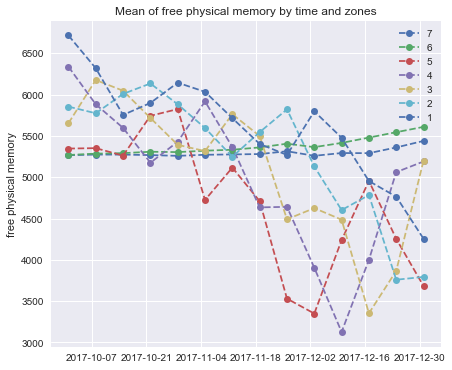

In [36]:
time_7 = df_cleaned[df_cleaned['zone'] == 7].set_index('date').groupby(pd.TimeGrouper('W')).mean().dropna().reset_index()
time_6 = df_cleaned[df_cleaned['zone'] == 6].set_index('date').groupby(pd.TimeGrouper('W')).mean().dropna().reset_index()
time_5 = df_cleaned[df_cleaned['zone'] == 5].set_index('date').groupby(pd.TimeGrouper('W')).mean().dropna().reset_index()
time_4 = df_cleaned[df_cleaned['zone'] == 4].set_index('date').groupby(pd.TimeGrouper('W')).mean().dropna().reset_index()
time_3 = df_cleaned[df_cleaned['zone'] == 3].set_index('date').groupby(pd.TimeGrouper('W')).mean().dropna().reset_index()
time_2 = df_cleaned[df_cleaned['zone'] == 2].set_index('date').groupby(pd.TimeGrouper('W')).mean().dropna().reset_index()
time_1 = df_cleaned[df_cleaned['zone'] == 1].set_index('date').groupby(pd.TimeGrouper('W')).mean().dropna().reset_index()


plt.figure(figsize=(7,6))

plt.title('Mean of free physical memory by time and zones')
plt.plot('date', 'free_physical_memory', data= time_7, marker='o', linestyle='dashed')
plt.plot('date', 'free_physical_memory', data= time_6, marker='o', linestyle='dashed')
plt.plot('date', 'free_physical_memory', data= time_5, marker='o', linestyle='dashed')
plt.plot('date', 'free_physical_memory', data= time_4, marker='o', linestyle='dashed')
plt.plot('date', 'free_physical_memory', data= time_3, marker='o', linestyle='dashed')
plt.plot('date', 'free_physical_memory', data= time_2, marker='o', linestyle='dashed')
plt.plot('date', 'free_physical_memory', data= time_1, marker='o', linestyle='dashed')
plt.ylabel('free physical memory')
plt.legend(['7', '6', '5', '4', '3', '2', '1'])
plt.show()

### Statistical Analysis

Let's start with plotting the correlation heatmap for the dataset:

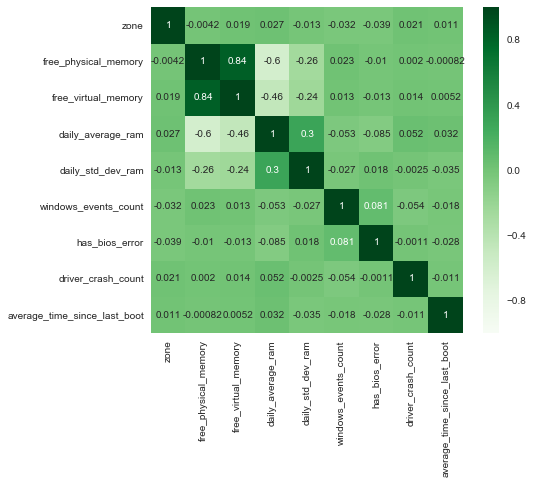

In [262]:
#Calculate correlations between the features and predictor
correlations = df_cleaned.corr()

#Make the figsize 7 x 6
plt.figure(figsize=(7,6))

#Plot heatmap of correlations
_ = sns.heatmap(correlations, cmap="Greens", annot=True)

As can be seen, 'zone' variable has a very small correlations with the predictors in the data set, which can be explained by the small absolute change of the predictors as a device progresses from one zone to another. At the same time, several predictors have substantial correlations: 'free_virtual_memory' is strongly positively correlated with 'free_physical_memory', which make sense--larger virtual memory frees up more space in physical memory. 'daily_average_ram' and 'daily_std_dev_ram' are negatively correlated with 'free_physical_memory', which also makes sense, as the average RAM usage decreases if the amount of free physical memory increases. Lastly, there's a small positive correlation between 'daily_average_ram' and 'daily_std_dev_ram', which means that the distribution of the average RAM usage becomes more widespread as that average increases.

### Statistical significance

**Note to Kenneth**: I believe that the proper test to use here would be a 2-sample t-test, and the samples could be 'healthy' devices (zones 6-7) vs. 'unhealthy' (zones 1-5), but does that test make sense at all in this case? If I'm to fit a penalized logistic regression, the predictors of no predictive significance will be eliminated. Neural networks don't need feature engineering to build a model (to my understanding). I've done a lot of such significance tests in my previous capstone, but their results weren't really used in the consequent modelling. The correlation matrix above shows almost no correlation between the zones and the variables, so do I really need to dig deeper into statistical significance?

### General notes to myself

**Notes from the mentor calls**


- finding a category that separates numeric into 2 sets, separate each into 2 based on some numeric feature for chi-square

- multiple hypothesis testing in my case - when i pick an alpha, then i do a correction (read about it), it's multiplication, and it will be that something 

multi-class classification - one-vs-all strategy (look into that), since i have 0 to 6 zones. fitting one against the rest, doing it 5 times, and the highest probability becomes the zone. keras should have that. apply general first - logistic, random forest, then try keras. try models on a much smaller subset (100-150k, random sampling, stratified sampling (should be same proportion as larger dataset for all features), then fit the final model to the big dataset to check. 

imbalance to try: undersampling; SMLTE; SMOTE technique in Python. look at the imblearn module (imbalance learn) on scikit. downsample to 5k all, 

benchmark: naive dummy model performance (random guessing, http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) vs. my model performance, precision/recall, and finally also Kappa

logistic regr - 0 against the rest, then 1 against the rest (scikit learn should have something), random forest; then try neural network on that 5k downsampled (for computation efficiency) and see how it goes.

train-test split - make sure the proportion of classes stays the same

stats - chi-square test on determining if at least one of the zones is statistically different